# LSTM approach

Load Data

In [71]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

df.drop(columns=['Lat', 'Long', 'Province/State'], inplace=True)

df = df[df['Country/Region'] == 'Singapore']

df_melt = pd.melt(df.iloc[:,1:], var_name='ds', value_name='y')

df_new = df_melt.y

df_new

0          0
1          1
2          3
3          3
4          4
       ...  
320    58273
321    58285
322    58291
323    58297
324    58305
Name: y, Length: 325, dtype: int64

Train-test split

In [72]:
# Split Train-Val into 90-10

test_set = df_new[-round(len(df_new)*0.1):].values

train_set = df_new[:-len(test_set)].values

print(len(train_set), len(test_set))

293 32


Normalise the data

In [73]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

train_set_norm = scaler.fit_transform(train_set.reshape(-1,1))

print(train_set_norm.shape)
print(train_set_norm[:5])

(293, 1)
[[0.00000000e+00]
 [1.72223753e-05]
 [5.16671259e-05]
 [5.16671259e-05]
 [6.88895012e-05]]


Creating Moving Window

In [74]:
import numpy as np

X_train = []
y_train = []

observ = 30 #Number of observations to base your prediction on

for i in range(observ, len(train_set_norm)):
  X_train.append(train_set_norm[i-observ:i])
  y_train.extend(train_set_norm[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape, y_train.shape)

(263, 30, 1) (263,)


In [75]:
total_test = df_new[-(len(test_set) + observ):].values # use the last 60 days of train to predict 1st day of test

test_set_norm = scaler.transform(total_test.reshape(-1,1))

test_set_norm.shape

(62, 1)

In [76]:
X_test = []
y_test = []

for i in range(observ, len(test_set_norm)):
  X_test.append(test_set_norm[i-observ:i])
  y_test.extend(test_set_norm[i])

X_test, y_test = np.array(X_test), np.array(y_test)

print(X_test.shape, y_test.shape)

(32, 30, 1) (32,)


Define Model

In [77]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers

lstm_input = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = LSTM(128)(lstm_input)
x = Dropout(0.2)(x)
x = Dense(64)(x)
x = Activation('sigmoid')(x)
x = Dense(1)(x)

output = Activation('linear')(x)

model = Model(inputs=lstm_input, outputs=output)

model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 30, 1)]           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_8 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_9 (Activation)    (None, 1)                

In [78]:
model.compile(loss='mse', optimizer='adam')

Train the model

In [79]:
history = model.fit(X_train, y_train,
                    epochs=13,
                    batch_size=72,
                    validation_data=(X_test, y_test),
                    verbose=2,
                    shuffle=False)

Epoch 1/13
4/4 - 1s - loss: 0.6645 - val_loss: 0.7752
Epoch 2/13
4/4 - 0s - loss: 0.2219 - val_loss: 0.0477
Epoch 3/13
4/4 - 0s - loss: 0.0486 - val_loss: 0.0703
Epoch 4/13
4/4 - 0s - loss: 0.0308 - val_loss: 0.0091
Epoch 5/13
4/4 - 0s - loss: 0.0317 - val_loss: 0.0532
Epoch 6/13
4/4 - 0s - loss: 0.0273 - val_loss: 0.0238
Epoch 7/13
4/4 - 0s - loss: 0.0138 - val_loss: 9.8576e-05
Epoch 8/13
4/4 - 0s - loss: 0.0192 - val_loss: 0.0023
Epoch 9/13
4/4 - 0s - loss: 0.0191 - val_loss: 5.0138e-04
Epoch 10/13
4/4 - 0s - loss: 0.0125 - val_loss: 0.0082
Epoch 11/13
4/4 - 0s - loss: 0.0111 - val_loss: 0.0058
Epoch 12/13
4/4 - 0s - loss: 0.0062 - val_loss: 4.0003e-06
Epoch 13/13
4/4 - 0s - loss: 0.0063 - val_loss: 4.4352e-04


Evaluation

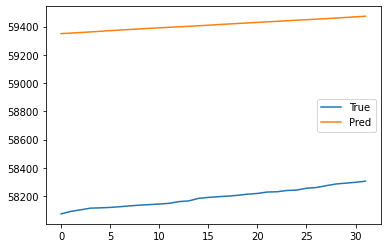

In [80]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred)

plt.plot(test_set, label = "True")
plt.plot(y_pred, label = "Pred")

plt.legend()
plt.show()

Retrain model on 100% of data

In [84]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

train_set = df_new.values

scaler = MinMaxScaler(feature_range=(0,1))

train_set_norm = scaler.fit_transform(train_set.reshape(-1,1))

X_train = []
y_train = []

observ = 30 #Number of observations to base your prediction on

for i in range(observ, len(train_set_norm)):
  X_train.append(train_set_norm[i-observ:i])
  y_train.extend(train_set_norm[i])

X_train, y_train = np.array(X_train), np.array(y_train)

X_test = df_new[-observ:].values 

X_test = scaler.transform(X_test.reshape(-1,1))

X_test = X_test.reshape(1, observ, 1)

print(len(train_set), len(test_set))
print(X_train.shape, y_train.shape)
print(X_test.shape)

325 32
(295, 30, 1) (295,)
(1, 30, 1)


In [85]:
history = model.fit(X_train, y_train,
                    epochs=13,
                    batch_size=72,
                    verbose=1,
                    shuffle=False)

y_pred = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred)

Epoch 1/13
5/5 [==============================] - 0s 38ms/step - loss: 0.0028
Epoch 2/13
5/5 [==============================] - 0s 37ms/step - loss: 0.0031
Epoch 3/13
5/5 [==============================] - 0s 39ms/step - loss: 0.0029
Epoch 4/13
5/5 [==============================] - 0s 38ms/step - loss: 0.0025
Epoch 5/13
5/5 [==============================] - 0s 38ms/step - loss: 0.0031
Epoch 6/13
5/5 [==============================] - 0s 39ms/step - loss: 0.0041
Epoch 7/13
5/5 [==============================] - 0s 36ms/step - loss: 0.0050
Epoch 8/13
5/5 [==============================] - 0s 37ms/step - loss: 0.0038
Epoch 9/13
5/5 [==============================] - 0s 37ms/step - loss: 0.0033
Epoch 10/13
5/5 [==============================] - 0s 37ms/step - loss: 0.0026
Epoch 11/13
5/5 [==============================] - 0s 38ms/step - loss: 0.0028
Epoch 12/13
5/5 [==============================] - 0s 39ms/step - loss: 0.0028
Epoch 13/13
5/5 [==============================] - 0s 36ms/st

In [86]:
from datetime import datetime
from datetime import timedelta

date = datetime.strptime(df_melt.iloc[-1].ds, '%m/%d/%y') + timedelta(days=1)

# Number of cases tomorrow
num_cases = y_pred[0][0] - df_melt.iloc[-1].y

if num_cases < 0:
  num_cases = 0

# number of cases tomorrow
print("Number of cases on {} is predicted to be {:.0f}.".format(date.date(), num_cases))

Number of cases on 2020-12-12 is predicted to be 0.
